In [15]:
import cv2
import glob
import matplotlib.pyplot as plt
import os
import face_recognition

%matplotlib inline

In [16]:
# DEFINE CONSTANTS
SIZE = (128, 128)
SAVE_DIRECTORY = 'resized_emoji_challenge_128_faces'

In [17]:
files_paths = glob.glob('emoji_challenge/*/*.jpg')
print(f'Total: {len(files_paths)}')
files_paths = [file for file in files_paths if 'problematic' not in file]
print(f'Excluding problematic: {len(files_paths)}')

Total: 200911
Excluding problematic: 199061


In [18]:
for folder in os.listdir('emoji_challenge'):
    if os.path.isdir(os.path.join('emoji_challenge', folder)):
        print(f'{folder}: {len(os.listdir(os.path.join("emoji_challenge", folder)))}')

surprise: 17031
eye_roll: 14580
surprise_problematic: 176
here_we_go: 21906
very_sad_problematic: 228
angry: 38750
disgust: 24357
clenched_teeth_problematic: 83
sad: 2691
disgust_problematic: 194
very_sad: 21670
kiss_problematic: 487
cringe: 11988
cringe_problematic: 115
sad_problematic: 20
clenched_teeth: 9732
angry_problematic: 396
kiss: 36356
eye_roll_problematic: 151


## Cropping and padding

emoji_challenge/surprise/6614827208382893317_frame_5.jpg


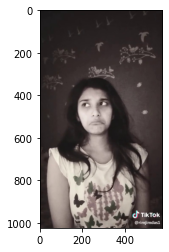

In [19]:
random_idx = 0
print(files_paths[random_idx])
image = cv2.imread(files_paths[random_idx])[...,::-1]
plt.imshow(image)

In [20]:
# This function crops the image to be square with its dimensions min(height, width) x min(height, width)
def crop_img(img): 
    center = (img.shape[0]//2, img.shape[1]//2)
    half_len = min(center[0], center[1])
    img = img[center[0]-half_len:center[0]+half_len, center[1]-half_len:center[1]+half_len]
    return img

In [21]:
# This function zero-pads the image on the top+bottom/left+right so that it's a square
def zero_pad_img(img):
    height, width, channels = img.shape
    if width > height:
        pad_amt = (width - height) // 2
        img = cv2.copyMakeBorder(img, pad_amt, pad_amt, 0, 0, cv2.BORDER_CONSTANT, value=0)
    else:
        pad_amt = (height - width) // 2
        img = cv2.copyMakeBorder(img, 0, 0, pad_amt, pad_amt, cv2.BORDER_CONSTANT, value=0)
    return img

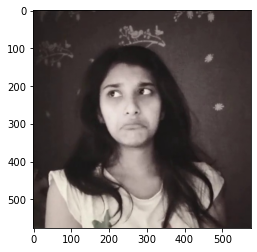

In [22]:
crop_image = crop_img(image)
plt.imshow(crop_image)

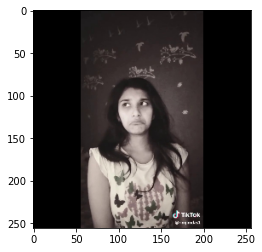

In [23]:
pad_image = zero_pad_img(image)
pad_image = cv2.resize(pad_image, (256, 256))
plt.imshow(pad_image)

## Remove sketched emojies
Many of the images are in the shape of a square and have a picture of a person on the left and a picture of a hand-drawn emoji on the right. We don't care about the emoji on the right, so we want to remove it. 

In [24]:
sketch_image_file = 'emoji_challenge/angry_subset/6614506069496433926_frame_14.jpg'
sketch_image = cv2.imread(sketch_image_file)[...,::-1]
plt.imshow(sketch_image)

TypeError: 'NoneType' object is not subscriptable

In [25]:
# Returns the proportion of an image's height to its width
def dimension_prop(img): 
    height, width, n_channels = img.shape
    return height / width

In [26]:
# Returns original image if original image is tall, otherwise cuts it in half widthwise
def tall_image(img): 
    img_prop = dimension_prop(img)
    if img_prop < 1.25: # arbitrary boundary, we can try other stuff too
        width = img.shape[1] // 2
        return img[:, :width, :]
    else: 
        return img

In [27]:
print(f'Image: {dimension_prop(image)}')
print(f'Sketch image: {dimension_prop(sketch_image)}')

Image: 1.7777777777777777


NameError: name 'sketch_image' is not defined

In [28]:
sketch_image_tall = tall_image(cv2.imread(sketch_image_file))[...,::-1]
plt.imshow(sketch_image_tall)

AttributeError: 'NoneType' object has no attribute 'shape'

In [29]:
# %%time
# if not os.path.exists('resized_emoji_challenge'):
#     os.makedirs('resized_emoji_challenge')
# for file in files_paths:
#     relative_path = os.path.join(*(file.split(os.path.sep)[1:]))
#     folder, filename = os.path.split(relative_path)
#     if not os.path.exists(os.path.join('resized_emoji_challenge', folder)):
#         os.makedirs(os.path.join('resized_emoji_challenge', folder))
#     image = cv2.imread(file)
#     image = tall_image(image)
#     if not len(face_recognition.face_locations(image)): 
#         continue
#     image = zero_pad_img(image)
#     image = cv2.resize(image, (256, 256))
#     cv2.imwrite(os.path.join('resized_emoji_challenge/', folder, filename), image)

# Try out RetinaFace face detector


In [30]:
# Returns tuple of location of the largest face in the image
def find_face_loc(locations):
    max_area = 0
    max_loc = (0, 0, 0, 0)
    for tup in locations: 
        top, right, bottom, left = tup
        area = (bottom - top) * (right - left)
        max_area = area if area > max_area else max_area
        max_loc = tup if area == max_area else max_loc
    return max_loc

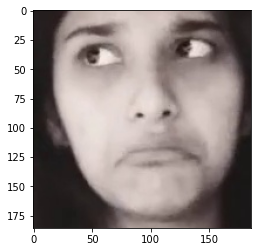

In [31]:
# Returns cropped image of largest face in the photo (or uncropped image if no face found)
def crop_face(img): 
    locations = face_recognition.face_locations(img)
    face_loc = find_face_loc(locations)
    if face_loc == (0, 0, 0, 0): 
        return None
    top, right, bottom, left = face_loc
    return img[top:bottom, left:right, :]
plt.imshow(crop_face(image))

In [ ]:
%%time
if not os.path.exists(SAVE_DIRECTORY):
    os.makedirs(SAVE_DIRECTORY)
for file in files_paths:
    relative_path = os.path.join(*(file.split(os.path.sep)[1:]))
    folder, filename = os.path.split(relative_path)
    if not os.path.exists(os.path.join(SAVE_DIRECTORY, folder)):
        os.makedirs(os.path.join(SAVE_DIRECTORY, folder))
    image = cv2.imread(file)
    image = tall_image(image)
    image = crop_face(image)
    if image is None: 
        continue
    image = zero_pad_img(image)
    image = cv2.resize(image, SIZE)
    cv2.imwrite(os.path.join(f'{SAVE_DIRECTORY}/', folder, filename), image)